set()
FF Criteria Overlap for Prune Ratio 0.01


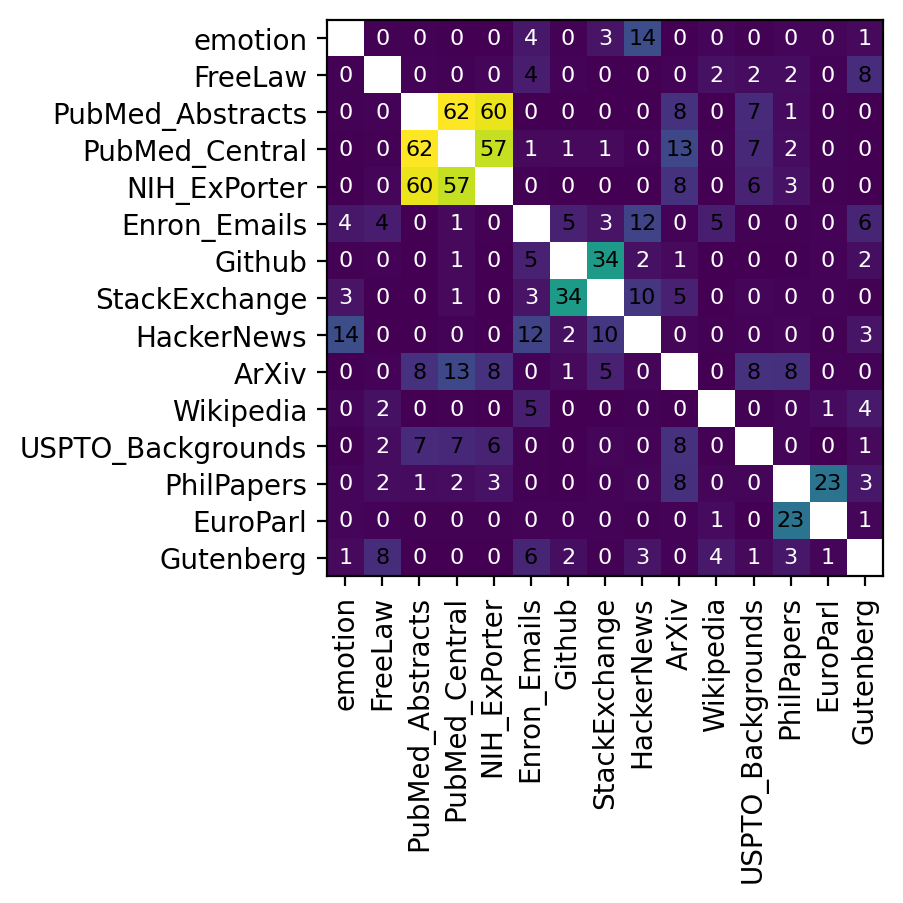

FF Criteria Overlap for Prune Ratio 0.01


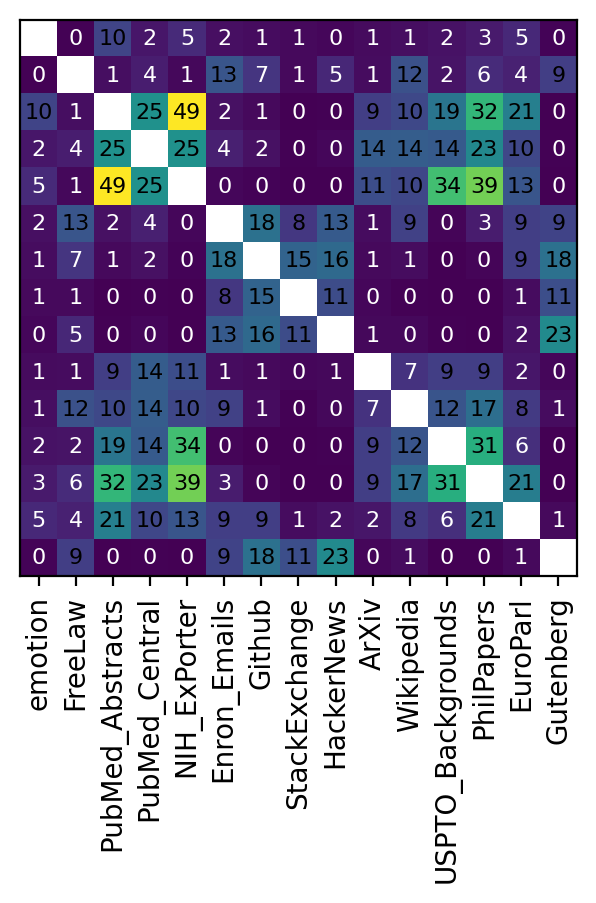

'\ncomparison = compare_pruned_ff_criteria(\n    datasets,\n    "rand",\n    path="./",\n    focus_repo="pile",\n    prune_ratio=prune_ratio,\n)\n\nplot_comparison(comparison)\n'

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from taker.activations import get_top_frac
import seaborn as sns

fallback_ratio = 0.01

def load_ff_criteria(directory, repo, focus_repo, suffix, fallback_suffix, device, ff_frac, layers="all"):
    try:
        assert layers == "all"
        repo1_tensors = torch.load(
            directory + repo + "-" + focus_repo + suffix,
            map_location=torch.device(device),
        )
        repo_ff_criteria = repo1_tensors["ff_criteria"]

    except:
        repo1_tensors = torch.load(
            directory + repo + "-" + focus_repo + fallback_suffix,
            map_location=torch.device(device),
        )
        repo_ff_scores = repo1_tensors["ff_scores"]
        if device == "cpu":
            repo_ff_scores = repo_ff_scores.to(torch.float32)
        if isinstance(layers, str) and layers == "all":
            layers = list(range(len(repo_ff_scores)))
        layers = np.array(layers)
        repo_ff_criteria, _threshold = get_top_frac(repo_ff_scores[layers], ff_frac)

    return repo_ff_criteria


def load_ff_criteria_auto(
        model_size: str,
        repo: str,
        prune_ratio: int,
        path: str = "./",
        focus_repo: str = "pile",
        device = "cpu",
        layers="all",
        ):
    directory = f"{path}{model_size}/"
    suffix = f"-{model_size}-{prune_ratio}-recent.pt"
    fallback_suffix = f"-{model_size}-recent.pt"

    return load_ff_criteria(directory, repo, focus_repo, suffix, fallback_suffix, device, prune_ratio, layers)



def compare_pruned_ff_criteria(
    cripple_repos: list[str],
    model_size: str,
    path: str = "/home/ubuntu/taker/tmp/saved_tensors/",
    focus_repo: str = "pile",
    prune_ratio: float = 0.01,
):
    # cripple_repos = ["physics", "bio", "code"]
    directory = f"{path}{model_size}/"
    suffix = f"-{model_size}-{prune_ratio}-recent.pt"
    fallback_suffix = f"-{model_size}-recent.pt"
    ratios = {}
    ratios["model_size"] = model_size

    device = "cuda" if torch.cuda.is_available() else "cpu"

    for repo1 in cripple_repos:
        # load ff_criteria from repo1
        repo1_ff_criteria = load_ff_criteria(directory, repo1, focus_repo, suffix, fallback_suffix, device, ff_frac=prune_ratio)
        ratios[repo1] = {}

        for repo2 in cripple_repos:
            if repo1 == repo2:
                ratios[repo1][repo2] = 0
            # load ff_criteria from repo2
            repo2_ff_criteria = load_ff_criteria(directory, repo2, focus_repo, suffix, fallback_suffix, device, ff_frac=prune_ratio)

            matches = torch.logical_and(repo1_ff_criteria, repo2_ff_criteria)
            ratio = torch.sum(matches) / torch.sum(repo1_ff_criteria
                                                   )
            ratios[repo1][repo2] = ratio

    return ratios

datasets = ["biology", "chemistry", "pile_PubMed_Abstracts", "pile_PubMed_Central", "pile_NIH_ExPorter", "pile_Enron_Emails", "code", "pile_Github",  "pile_StackExchange", "pile_Ubuntu_IRC", "pile_HackerNews", "poems", "civil", "emotion", "physics", "math", "pile_ArXiv", "pile_Wikipedia", "pile_USPTO_Backgrounds", "pile_PhilPapers", "pile_EuroParl", "pile_Gutenberg", "pile_FreeLaw"]
datasets_so_far = ["emotion", "pile_FreeLaw", "pile_PubMed_Abstracts", "pile_PubMed_Central", "pile_NIH_ExPorter", "pile_Enron_Emails", "pile_Github", "pile_StackExchange", "pile_HackerNews", "pile_ArXiv", "pile_Wikipedia", "pile_USPTO_Backgrounds", "pile_PhilPapers", "pile_EuroParl", "pile_Gutenberg"]
datasets = datasets_so_far

print(set(datasets)-set(datasets_so_far))

def plot_comparison(comparison, plot_yticks = True):
    grid = [
        [
            comparison[dataset_a][dataset_b].item() if dataset_a != dataset_b else np.nan
            for dataset_b in datasets
        ]
        for dataset_a in datasets
    ]
    grid = np.ma.masked_where(np.isnan(grid), grid)

    average = np.mean(grid)

    plt.figure(dpi=200)

    plt.imshow(grid)
    for i in range(len(datasets)):
        for j in range(len(datasets)):
            val = grid[i,j]
            try:
                int_val = int(val*100)
            except:
                int_val = val
            plt.text(
                j,
                i,
                f"{int_val}",#f"{grid[i, j]:.2f}",
                ha="center",
                va="center",
                color="black" if grid[i, j] > average else "white",
                fontsize=8,
            )
    plt.xticks(
        range(len(datasets)), [dataset.split("pile_")[-1] for dataset in datasets], rotation=90
    )
    plt.yticks(range(len(datasets)), [dataset.split("pile_")[-1] for dataset in datasets])

    if not plot_yticks:
        plt.gca().get_yaxis().set_visible(False)

    plt.subplots_adjust(bottom=0.3)

    print(f"FF Criteria Overlap for Prune Ratio {prune_ratio}")

    plt.show()


d[('pile_Github', 0.022), ('code', 0.024), ('physics', 0.016), ('chemistry', 0.004), ('biology', 0.04), ('pile_ArXiv', 0.048), ('pile_Enron_Emails', 0.020083984374999996), ('pile_EuroParl', 0.0025), ('pile_FreeLaw', 0.007), ('pile_Gutenberg', 0.008), ('pile_HackerNews', 0.048), ('pile_NIH_ExPorter', 0.048), ('pile_PhilPapers', 0.064), ('pile_PubMed_Abstracts', 0.032), ('pile_PubMed_Central', 0.04), ('pile_StackExchange', 0.048), ('pile_Ubuntu_IRC', 0.012), ('pile_USPTO_Backgrounds', 0.112), ('pile_Wikipedia', 0.046)]


prune_ratio = 0.01

comparison = compare_pruned_ff_criteria(
    datasets,
    "hf",#"Cifar100",
    path="./",
    focus_repo="pile",
    prune_ratio=0.01,
)

plot_comparison(comparison)

comparison = compare_pruned_ff_criteria(
    datasets,
    "rand",#"Cifar100",
    path="./",
    focus_repo="pile",
    prune_ratio=0.01,
)

plot_comparison(comparison, False)

"""
comparison = compare_pruned_ff_criteria(
    datasets,
    "rand",
    path="./",
    focus_repo="pile",
    prune_ratio=prune_ratio,
)

plot_comparison(comparison)
"""

FF Criteria Overlap for Prune Ratio 0.01


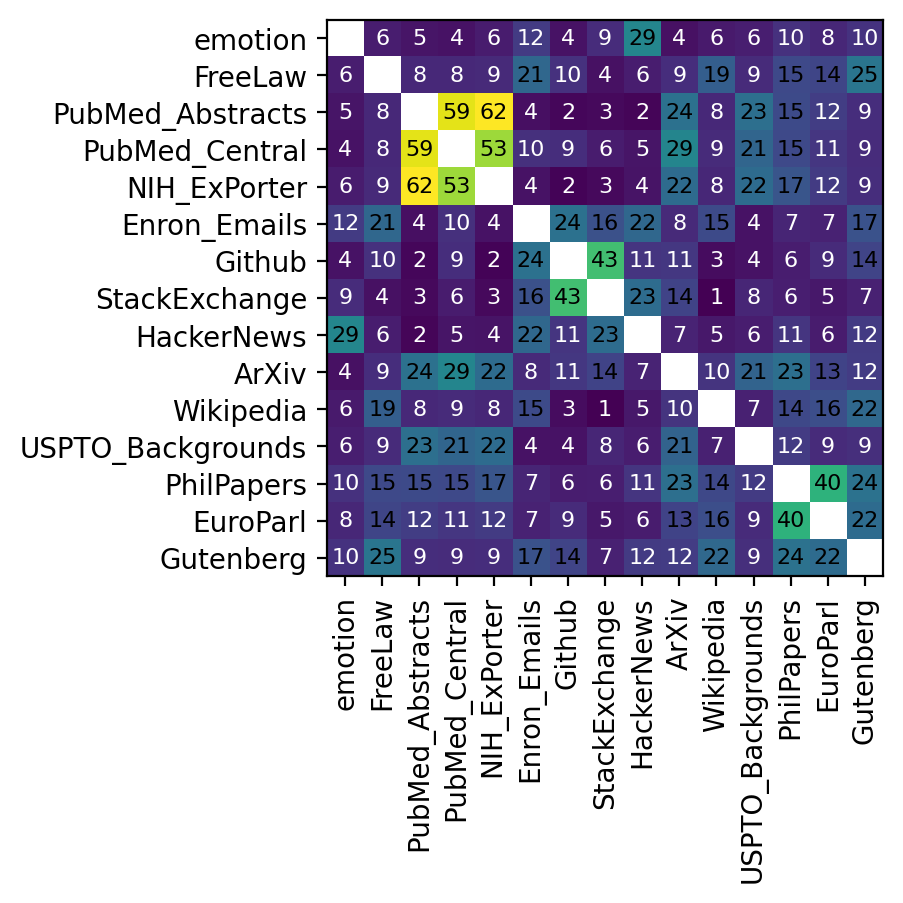

FF Criteria Overlap for Prune Ratio 0.01


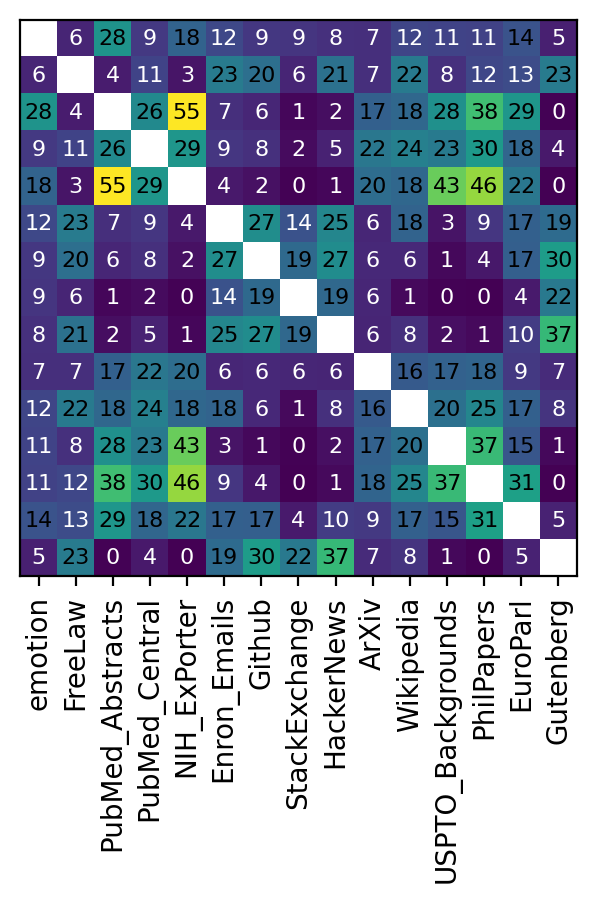

In [2]:

comparison = compare_pruned_ff_criteria(
    datasets,
    "hf",#"Cifar100",
    path="./",
    focus_repo="pile",
    prune_ratio=0.1,
)

plot_comparison(comparison)

comparison = compare_pruned_ff_criteria(
    datasets,
    "rand",#"Cifar100",
    path="./",
    focus_repo="pile",
    prune_ratio=0.1,
)

plot_comparison(comparison, False)

In [7]:

from tqdm import tqdm

rand_stats_dict = {"min": [], "mean": [], "median": [], "max": [], "std": []}

for frac in tqdm(range(1, 100)):
    comparison = compare_pruned_ff_criteria(
        datasets,
        "rand",#"Cifar100",
        path="./",
        focus_repo="pile",
        prune_ratio=0.01*frac,
    )
    #print(comparison)
    keys = list(comparison["emotion"].keys())
    dots = []
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys[i+1:]):
            # Assuming 'comparison[k1][k2]' is how you access your comparison metrics
            dots.append(comparison[k1][k2].item())
    dots = np.array(dots)
    rand_stats_dict["min"].append(np.min(dots))
    rand_stats_dict["mean"].append(np.mean(dots))
    rand_stats_dict["median"].append(np.median(dots))
    rand_stats_dict["max"].append(np.max(dots))
    rand_stats_dict["std"].append(np.std(dots))


good_stats_dict = {"min": [], "mean": [], "median": [], "max": [], "std": []}

for frac in tqdm(range(1, 100)):
    comparison = compare_pruned_ff_criteria(
        datasets,
        "hf",
        path="./",
        focus_repo="pile",
        prune_ratio=0.01*frac,
    )
    keys = list(comparison["emotion"].keys())
    dots = []
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys[i+1:]):
            # Assuming 'comparison[k1][k2]' is how you access your comparison metrics
            dots.append(comparison[k1][k2].item())
    dots = np.array(dots)
    good_stats_dict["min"].append(np.min(dots))
    good_stats_dict["mean"].append(np.mean(dots))
    good_stats_dict["median"].append(np.median(dots))
    good_stats_dict["max"].append(np.max(dots))
    good_stats_dict["std"].append(np.std(dots))

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [01:28<00:00,  1.12it/s]


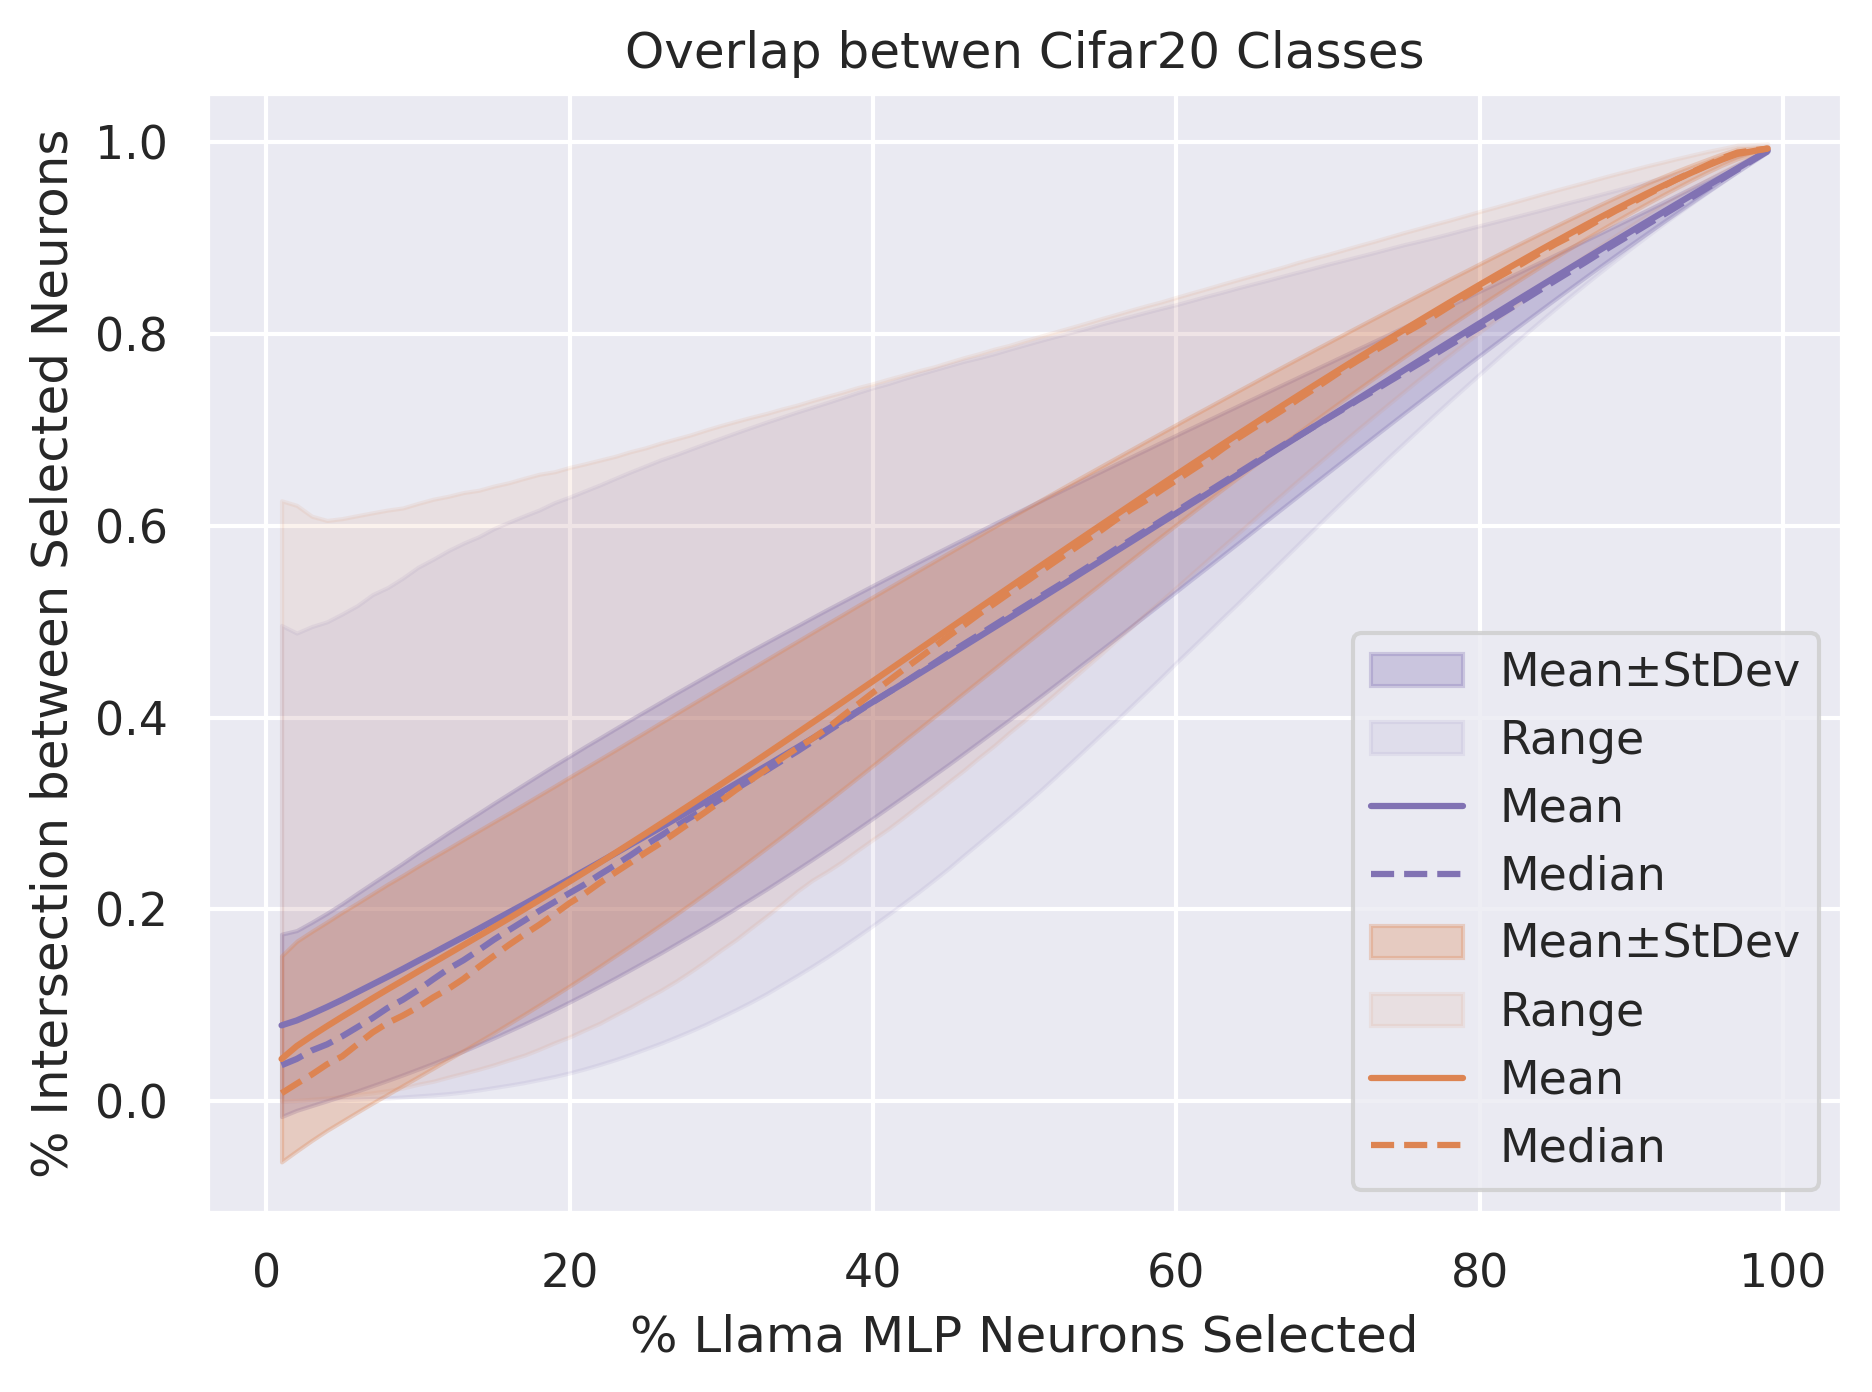

In [11]:

# Revised code to correctly aggregate statistics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

data = {
    "good": {
        "dict": good_stats_dict,
        "color": "C1",
    },
    "rand": {
        "dict": rand_stats_dict,
        "color": "m",
    }
}

for type in ["rand", "good"]:
    # Extract mean, median, and std for each iteration
    stats_dict = data[type]["dict"]
    means = stats_dict["mean"]
    medians = stats_dict["median"]
    std_devs = stats_dict["std"]

    # Set up x axis range
    x = range(1, 100)

    color = data[type]["color"]
    # Plotting mean and standard deviation as filled error bars
    plt.fill_between(x, np.subtract(means, std_devs), np.add(means, std_devs), color=color, alpha=0.3, label='Mean±StDev')
    plt.fill_between(x, stats_dict["min"], stats_dict["max"], color=color, alpha=0.1, label='Range')
    plt.plot(x, means, f"{color}-", label='Mean',)
    plt.plot(x, medians, f"{color}--", label='Median')

    # Additional plot settings
    plt.xlabel('% Llama MLP Neurons Selected')
    plt.ylabel('% Intersection between Selected Neurons')
    plt.title('Overlap betwen Cifar20 Classes')
    plt.legend(loc="lower right")
    plt.tight_layout()

plt.show()


## Load Clusters

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize as sk_normalize
from k_means_constrained import KMeansConstrained
from taker import Model

def cluster_neurons(model: Model,
        layer: int,
        split_num: int=96,
        method="kmeans",
    ):
    # First, get variables for which components are used
    assert model.cfg.d_mlp % split_num == 0, \
        "split_num should evenly divide model's mlp width"
    split_size = model.cfg.d_mlp // split_num

    # Collect the neurons we are clustering
    weights = model.layers[layer]["mlp.W_in"].detach().cpu()
    normed_weights = sk_normalize(weights)

    # Perform the clustering
    if method == "kmeans":
        kmeans = KMeansConstrained(
            n_clusters=split_num, size_min=split_size, size_max=split_size, random_state=0
        ).fit(normed_weights, None)
        labels = [x for x in kmeans.labels_]
        return labels, kmeans

    if method == "random":
         labels = np.array(list(range(model.cfg.d_mlp))) % split_num

from taker.model_maps import convert_hf_model_config
cfg = convert_hf_model_config("NousResearch/Llama-2-7b-hf")

print(cfg.n_layers, cfg.d_mlp)

32 11008


In [ ]:
def get_clustering(m):
    clusters = []

    for layer in range(m.cfg.n_layers):
        split_num: int=96
        cluster_i, _ = cluster_neurons(m, layer, split_num=split_num)
        print(cluster_i)
        cluster_i += np.ones_like(cluster_i) * split_num * layer
        clusters.append( cluster_i )

    clusters_list = np.array( clusters )
    clusters_list.shape
    return clusters_list

good_clusters_list = np.load("moe/llama-7b-moe-128.npy")
rand_clusters_list = np.load("moe/llama-7b-rand-moe-128.npy")

## Do Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_cumulative_counts(cluster_labels, selected_neurons):
    # Count selected neurons in each cluster
    unique_clusters = np.unique(cluster_labels)
    counts = {cluster: 0 for cluster in unique_clusters}
    for cluster in unique_clusters:
        counts[cluster] = selected_neurons[cluster_labels == cluster].sum()

    # Sort clusters by counts
    sorted_clusters = sorted(counts, key=counts.get, reverse=True)
    sorted_counts = [counts[cluster] for cluster in sorted_clusters]
    cumulative_counts = [0]
    for x in sorted_counts:
        cumulative_counts.append(cumulative_counts[-1] + x)
    return cumulative_counts

def plot_roc_curve(cluster_labels, selected_neurons, label="data point", **kwargs):
    cumulative_counts = get_cumulative_counts(cluster_labels, selected_neurons)

    # Plot sorted counts
    plt.plot(range(len(cumulative_counts)), cumulative_counts, label=label, **kwargs)
    plt.xlabel('Cumulative Number of Clusters')
    plt.ylabel('Cumulative Count of Selected Neurons')
    plt.title('ROC for placing Neurons into Balanced Clusters')
    plt.xticks(rotation=45)

    auc = area_under_curve(cumulative_counts)

    return auc

def area_under_curve(cumulative_counts):
    x = np.array(list(range(len(cumulative_counts))))
    y = cumulative_counts


    x_max = min([ y[-1], x[-1] ]) # if there is 30 neurons into 100 categories, then limit ROC to 30

    auc = np.sum(y[:x_max]) / ( y[x_max] * x_max )
    return auc


def get_optimal_auc(pruning_ratio):
    d_mlp = cfg.d_mlp
    split_num = 96

    split_size = d_mlp // split_num
    num_neurons = int(d_mlp * pruning_ratio)

    y = 0
    cumm_neurons = [0]
    for i in range(split_num):
        y += split_size
        if y > num_neurons:
            y = num_neurons
        cumm_neurons.append( y )

    return area_under_curve(cumm_neurons)

(32, 11008)
(32, 11008)


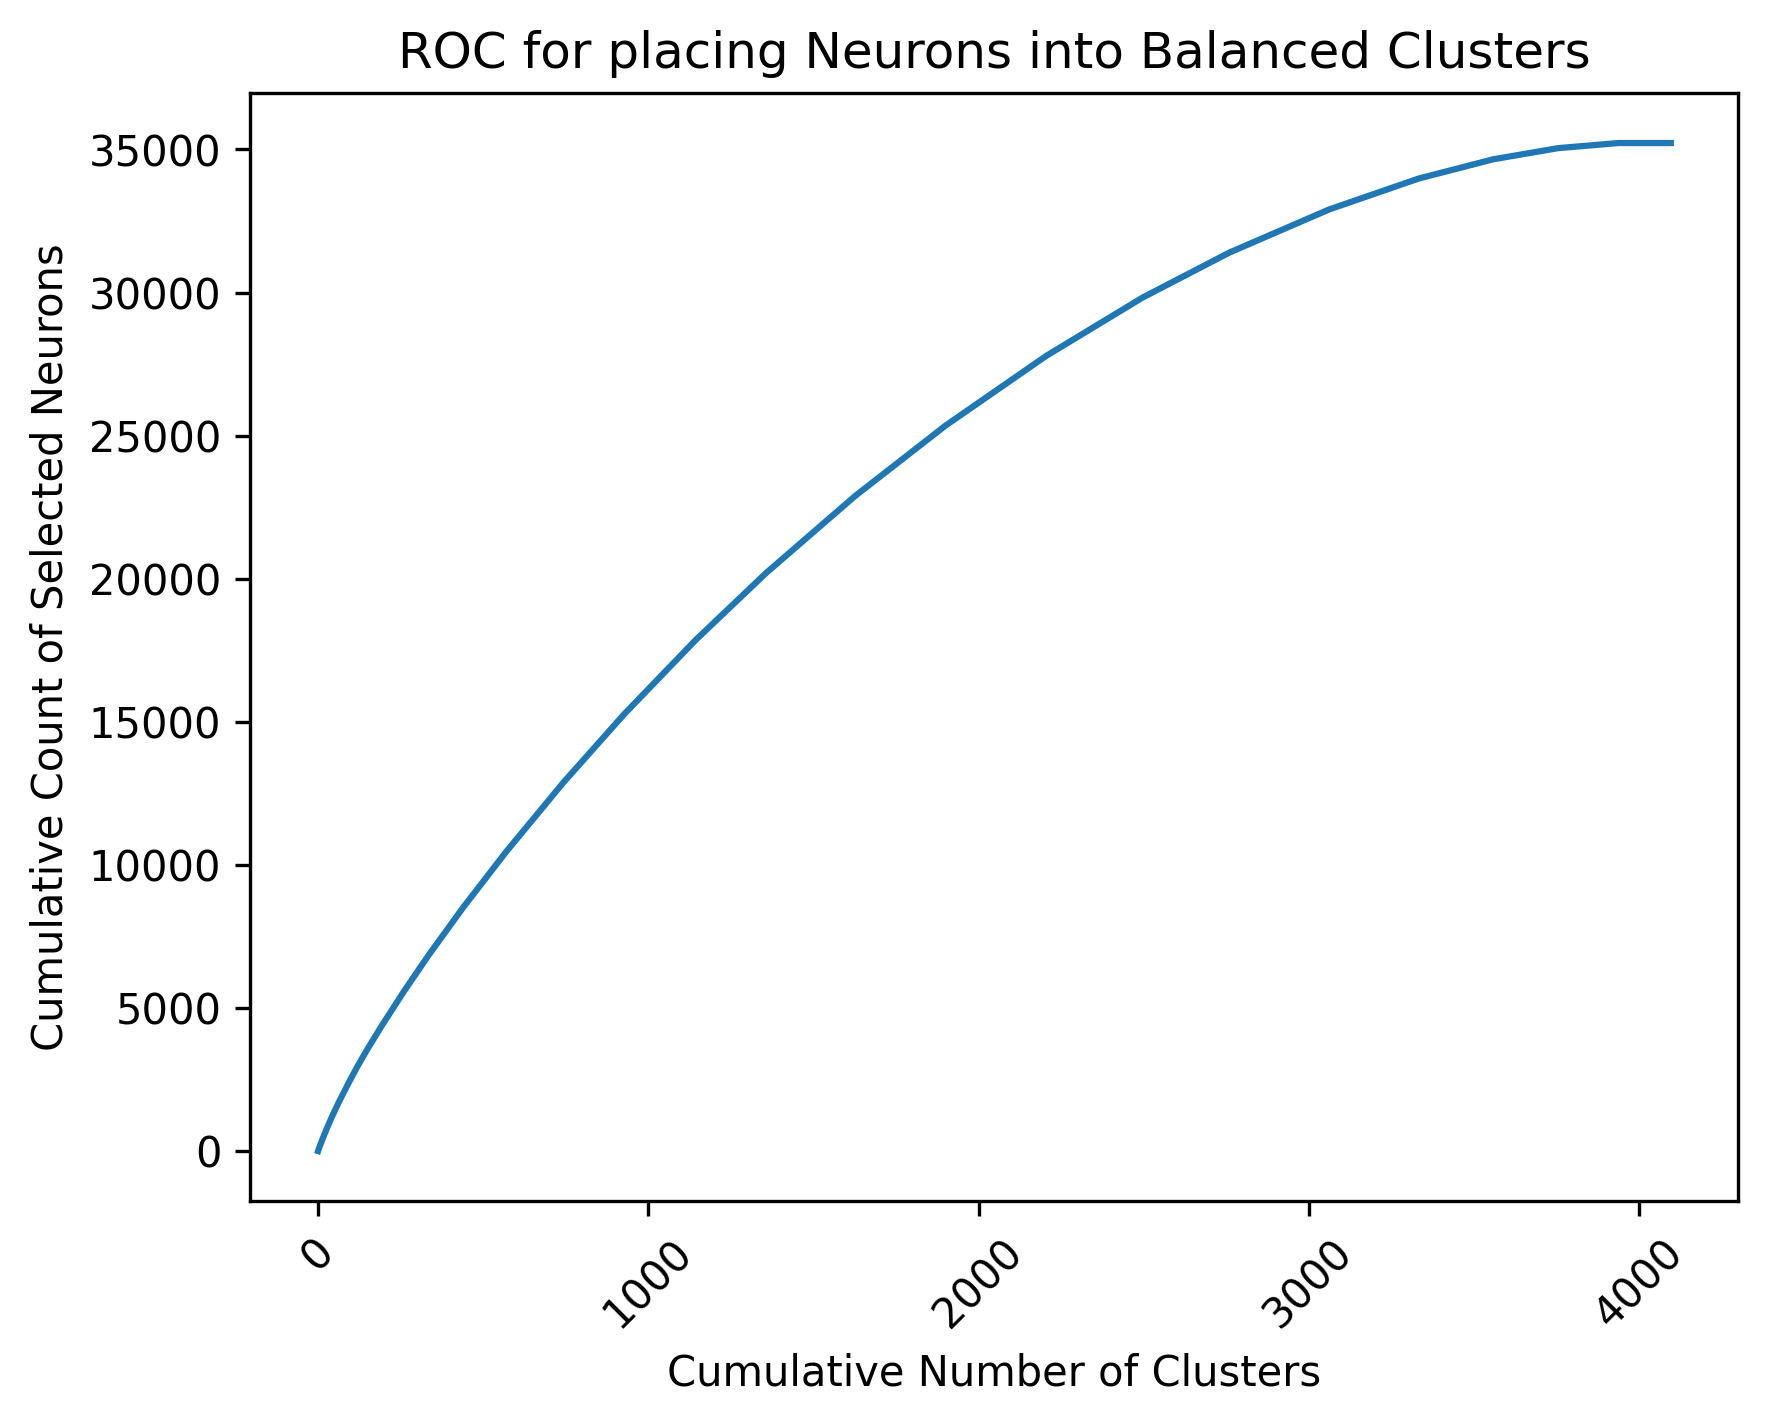

In [ ]:
#selected_rand = np.array( load_ff_criteria_auto("init", "cifar20-veh2", 0.1) )
selected_good = np.array( load_ff_criteria_auto("hf", "pile_FreeLaw", 0.1) )
print(selected_good.shape)
print(good_clusters_list.shape)

plot_roc_curve(good_clusters_list, selected_good)
#plot_roc_curve(rand_clusters_list, selected_rand)
#plot_roc_curve(rand_clusters_list, selected_good)
#plot_roc_curve(good_clusters_list, selected_rand)
plt.show()


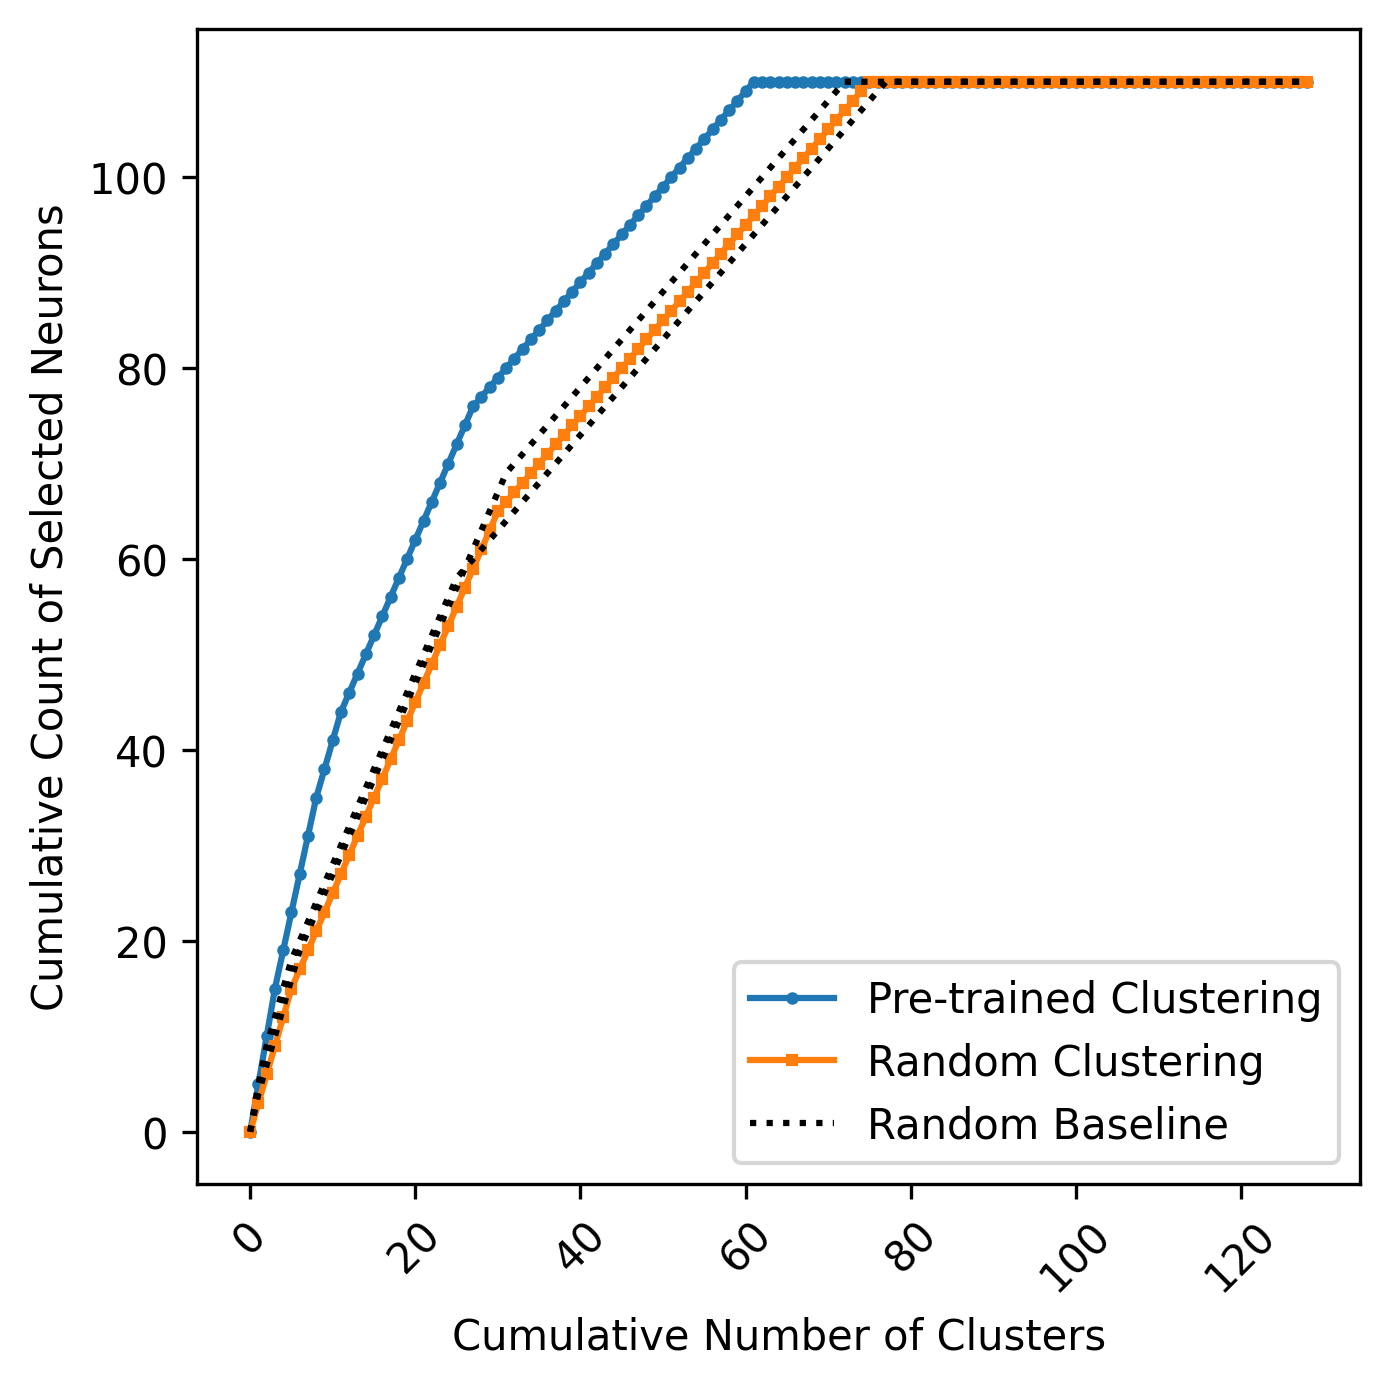

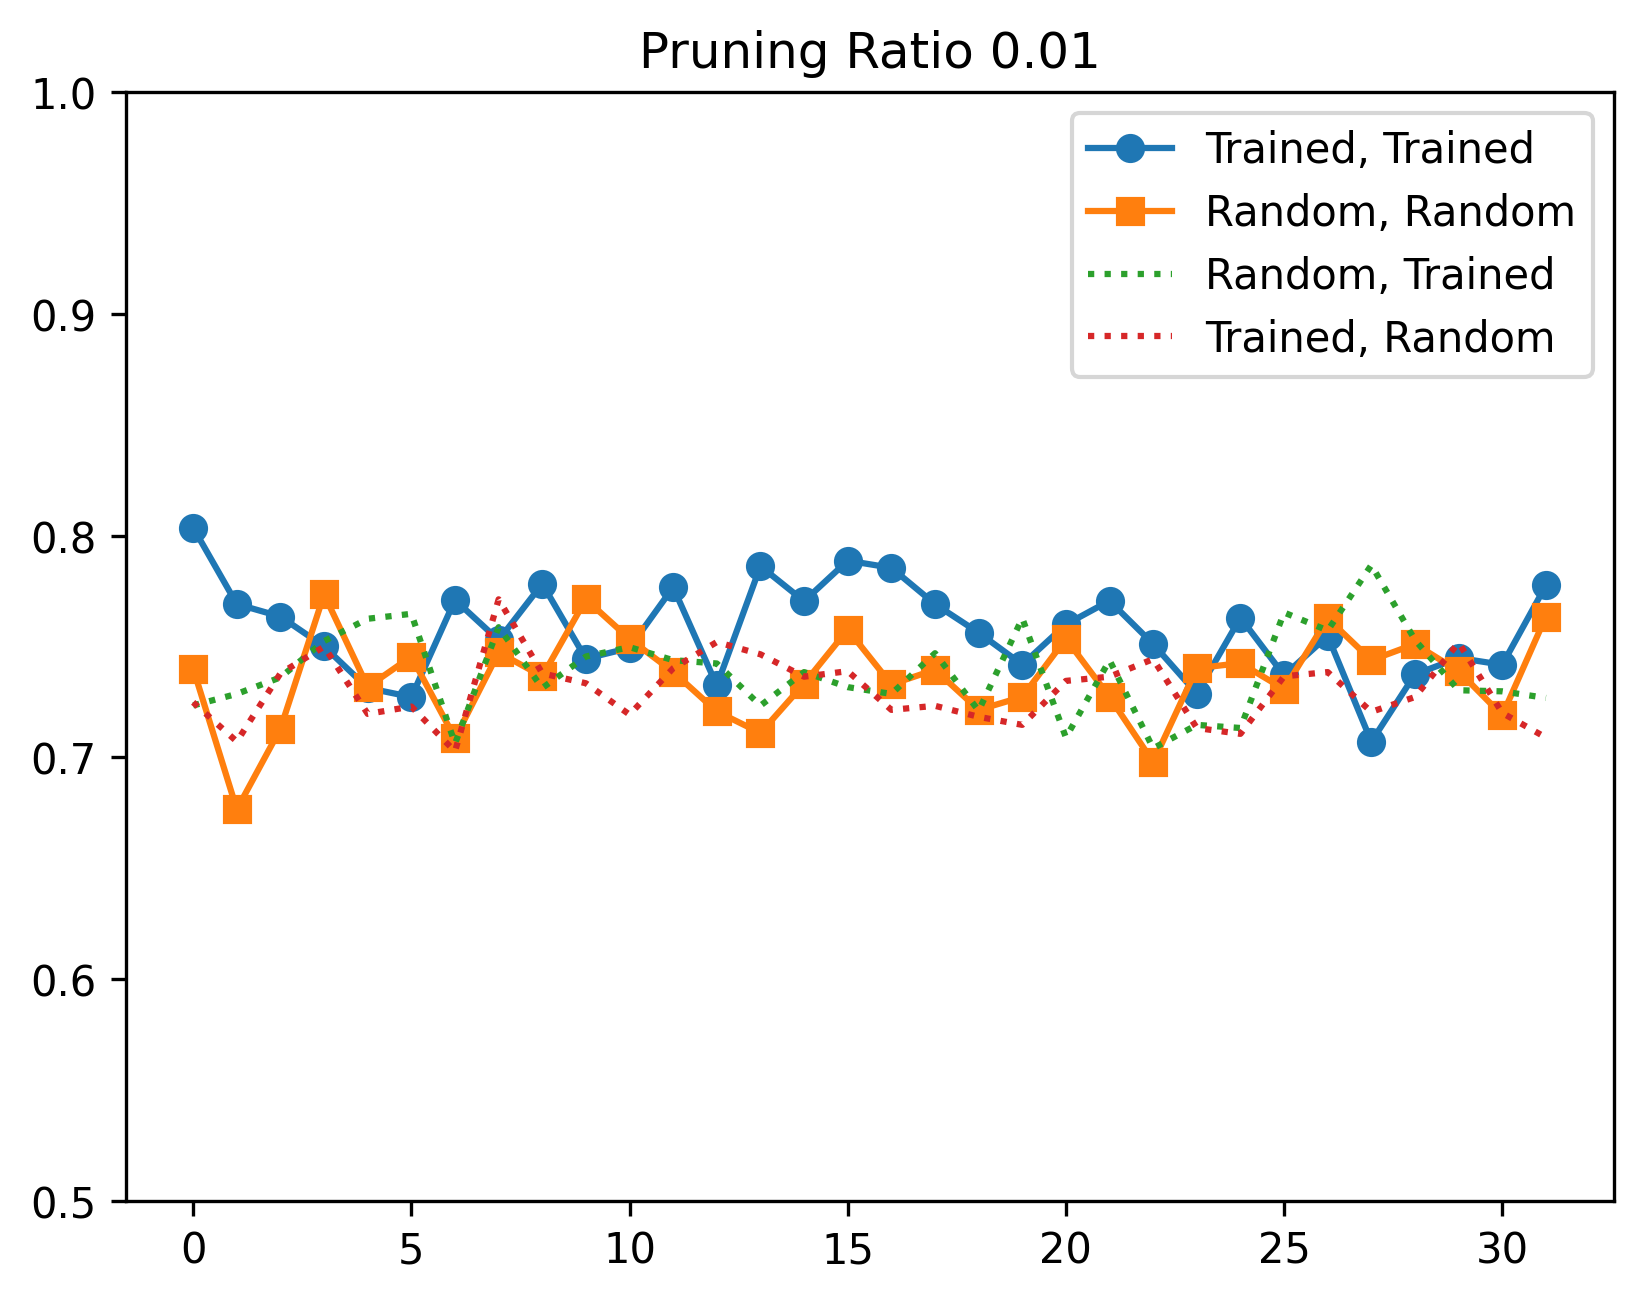

In [ ]:
all_layers = list(range(cfg.n_layers))
pruning_ratio = 0.01
#for pruning_ratio in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
for pruning_ratio in [pruning_ratio]:
    auc_tt, auc_rr, auc_rt, auc_tr = [], [], [], []
    for layer in all_layers:
        layers = [layer]
        good_ff_criteria = np.array( load_ff_criteria_auto("hf", "pile_FreeLaw", pruning_ratio, layers=layers) )
        rand_ff_criteria = np.array( load_ff_criteria_auto("rand", "pile_FreeLaw", pruning_ratio, layers=layers) )

        auc_tt.append( area_under_curve(get_cumulative_counts(good_clusters_list[layers], good_ff_criteria)) )
        auc_rr.append( area_under_curve(get_cumulative_counts(rand_clusters_list[layers], rand_ff_criteria)) )

        auc_rt.append( area_under_curve(get_cumulative_counts(rand_clusters_list[layers], good_ff_criteria)) )
        auc_tr.append( area_under_curve(get_cumulative_counts(good_clusters_list[layers], rand_ff_criteria)) )

        if layer == 0:
            plt.figure(figsize=(5,5))
            plot_roc_curve(good_clusters_list[layers], good_ff_criteria, label="Pre-trained Clustering", marker="o", markersize=2)
            plot_roc_curve(good_clusters_list[layers], rand_ff_criteria, label="Random Clustering", marker="s", markersize=2)
            plot_roc_curve(rand_clusters_list[layers], good_ff_criteria, label="Random Baseline", linestyle=":", color="k")
            plot_roc_curve(rand_clusters_list[layers], rand_ff_criteria, label="", linestyle=":", color="k")
            plt.title("")
            plt.legend()
            plt.show()

    plt.figure()
    plt.plot(all_layers, auc_tt, "-o", label="Trained, Trained")
    plt.plot(all_layers, auc_rr, "-s", label="Random, Random")
    plt.plot(all_layers, auc_rt, ":", label="Random, Trained")
    plt.plot(all_layers, auc_tr, ":", label="Trained, Random")
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.title(f"Pruning Ratio {pruning_ratio}")
    plt.show()

[0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334]
[[[0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.98958333333333

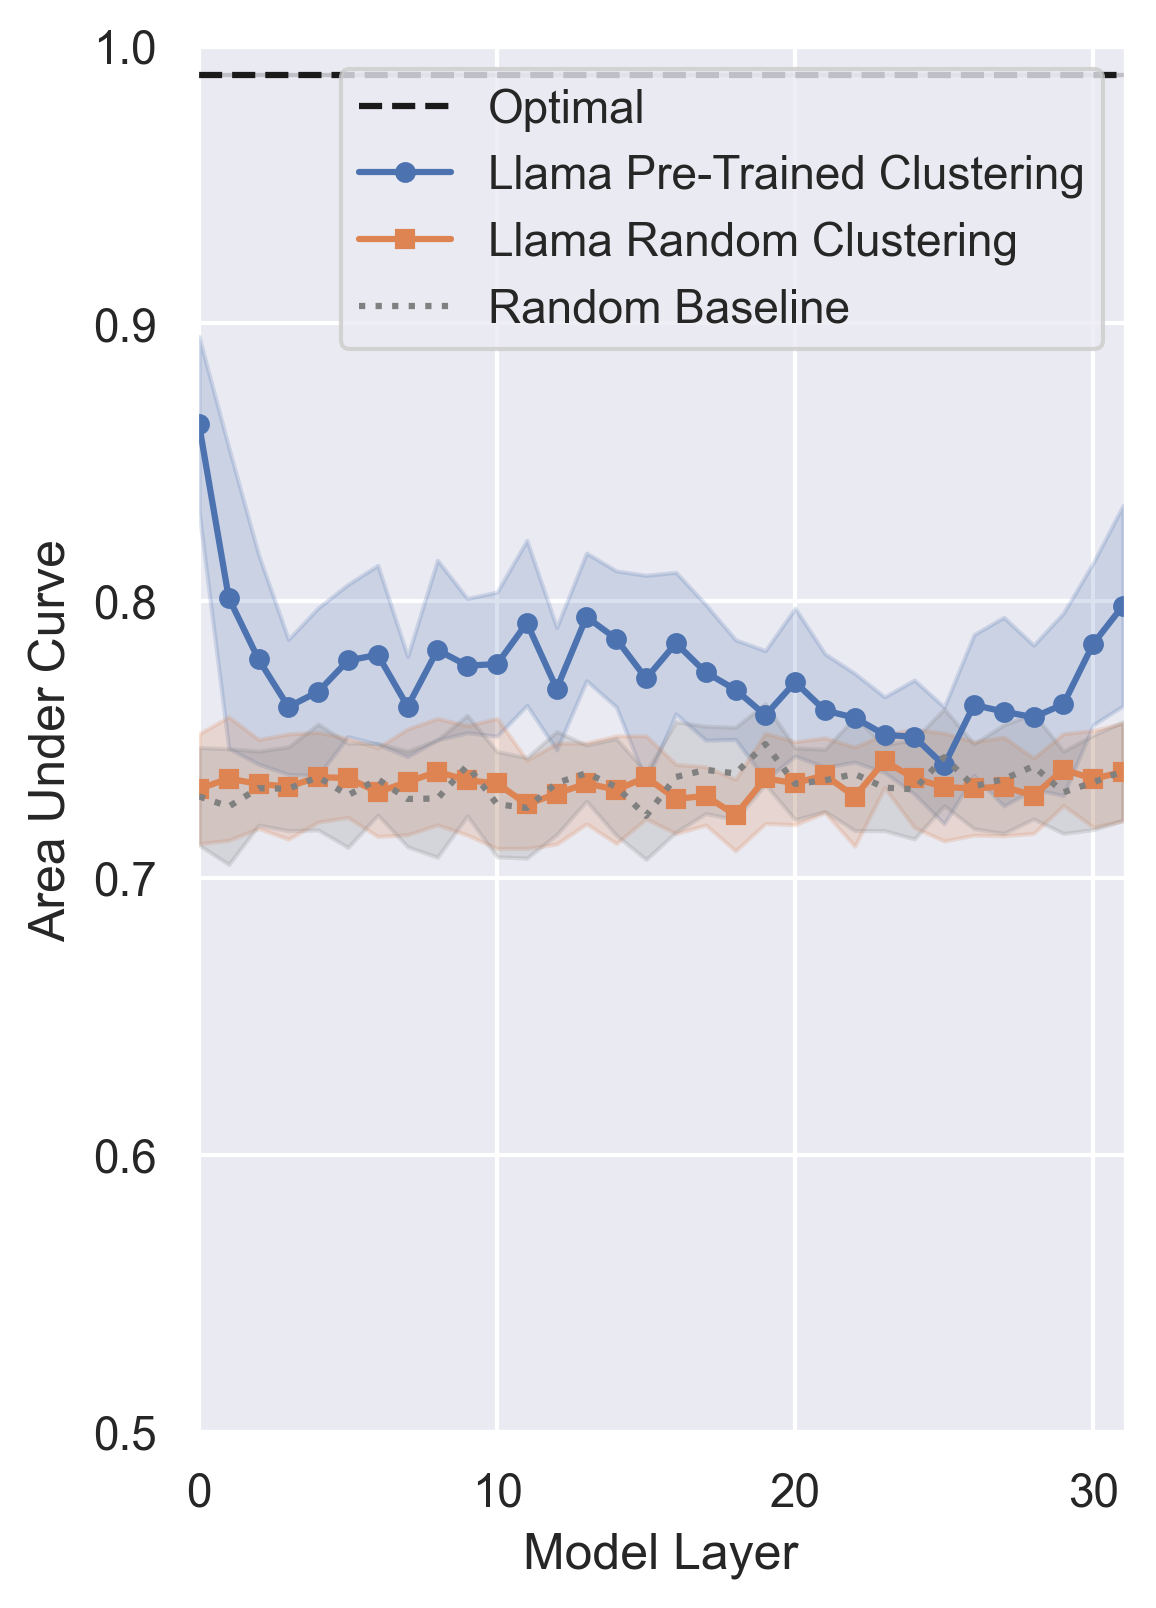

[0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394]
[[[0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564393939394, 0.984564

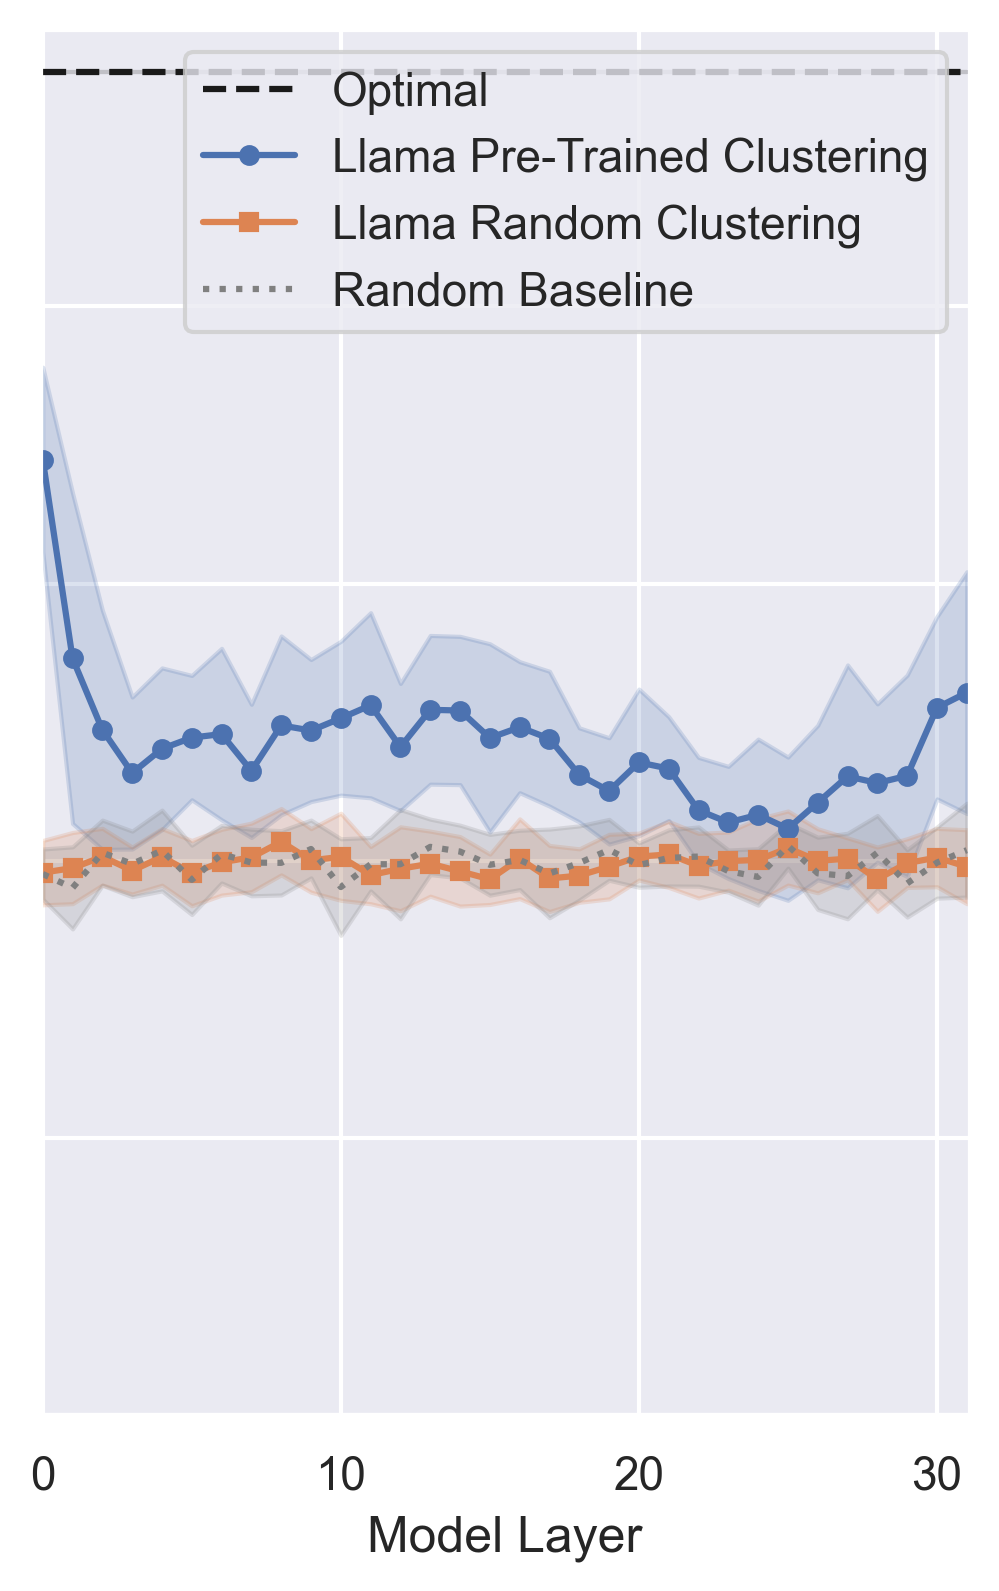

[0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757]
[[[0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.9695075757575757, 0.96950757575757

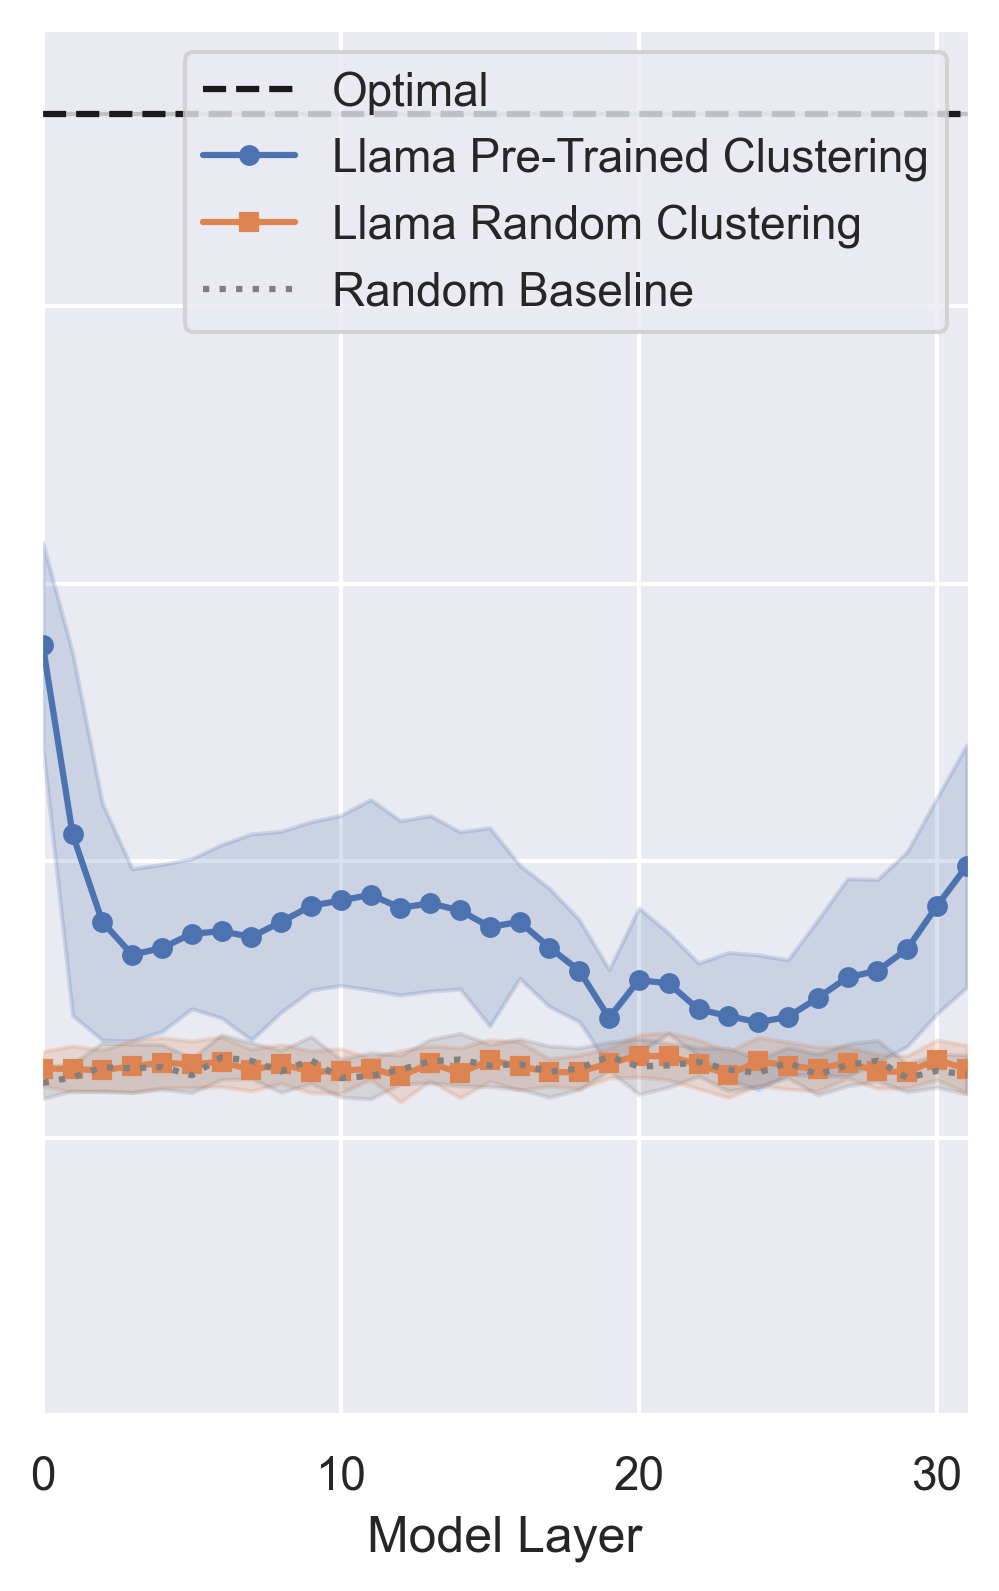

[0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788]
[[[0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.9444128787878788, 0.94441287878787

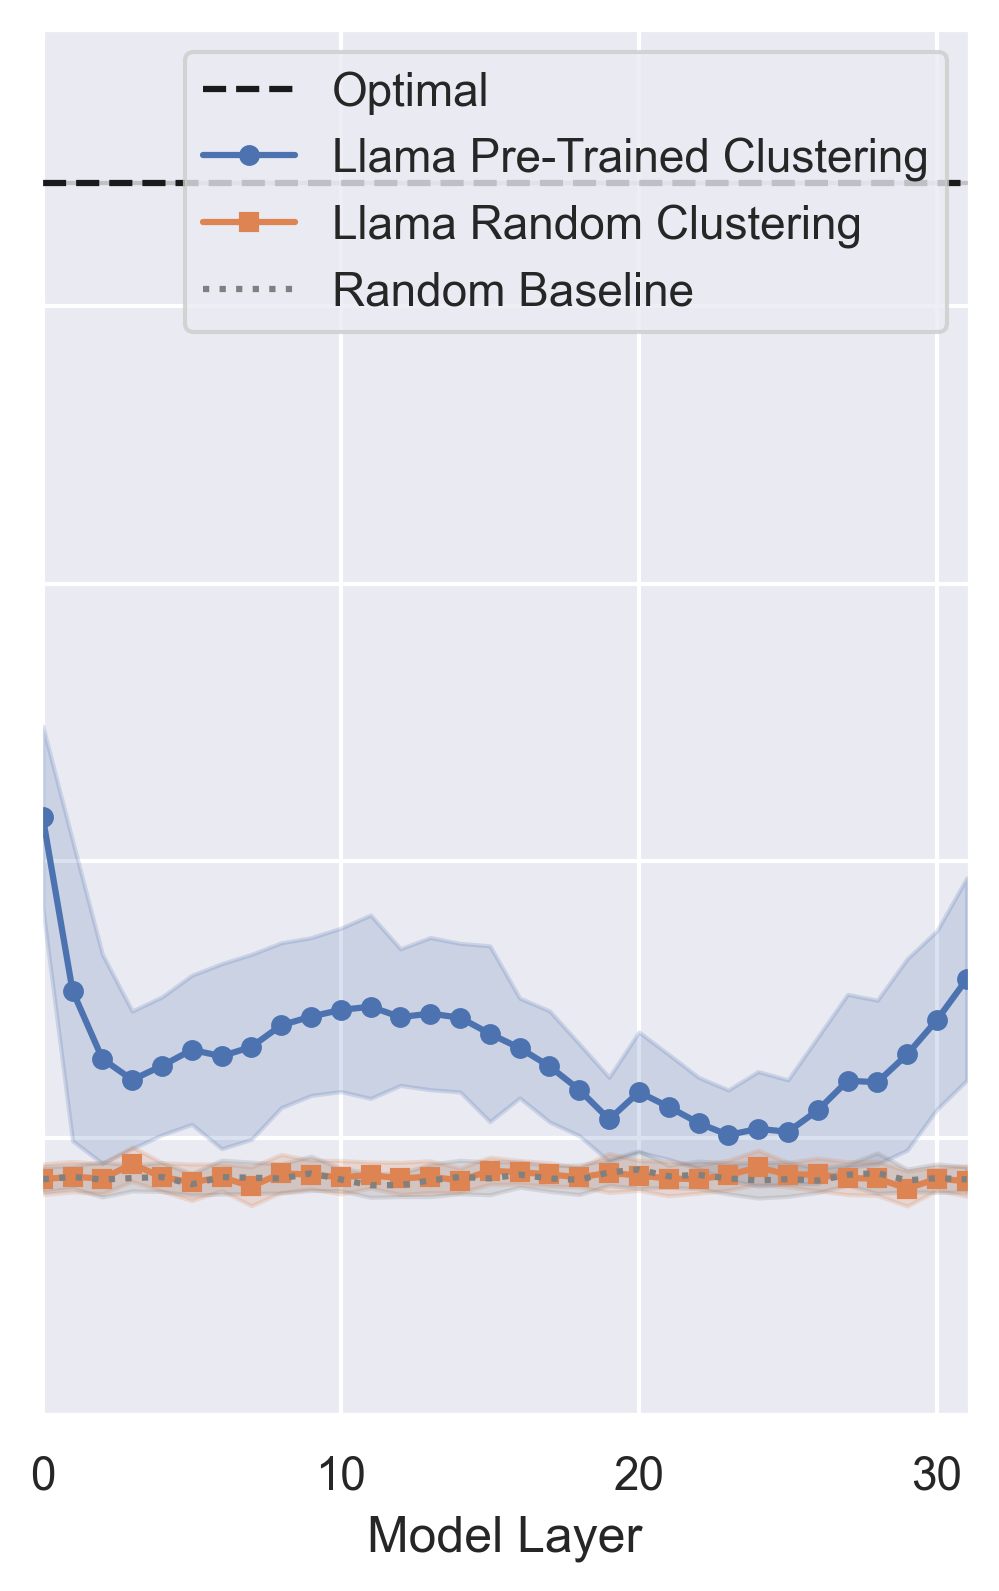

[0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457]
[[[0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.8941768892927457, 0.89417688929274

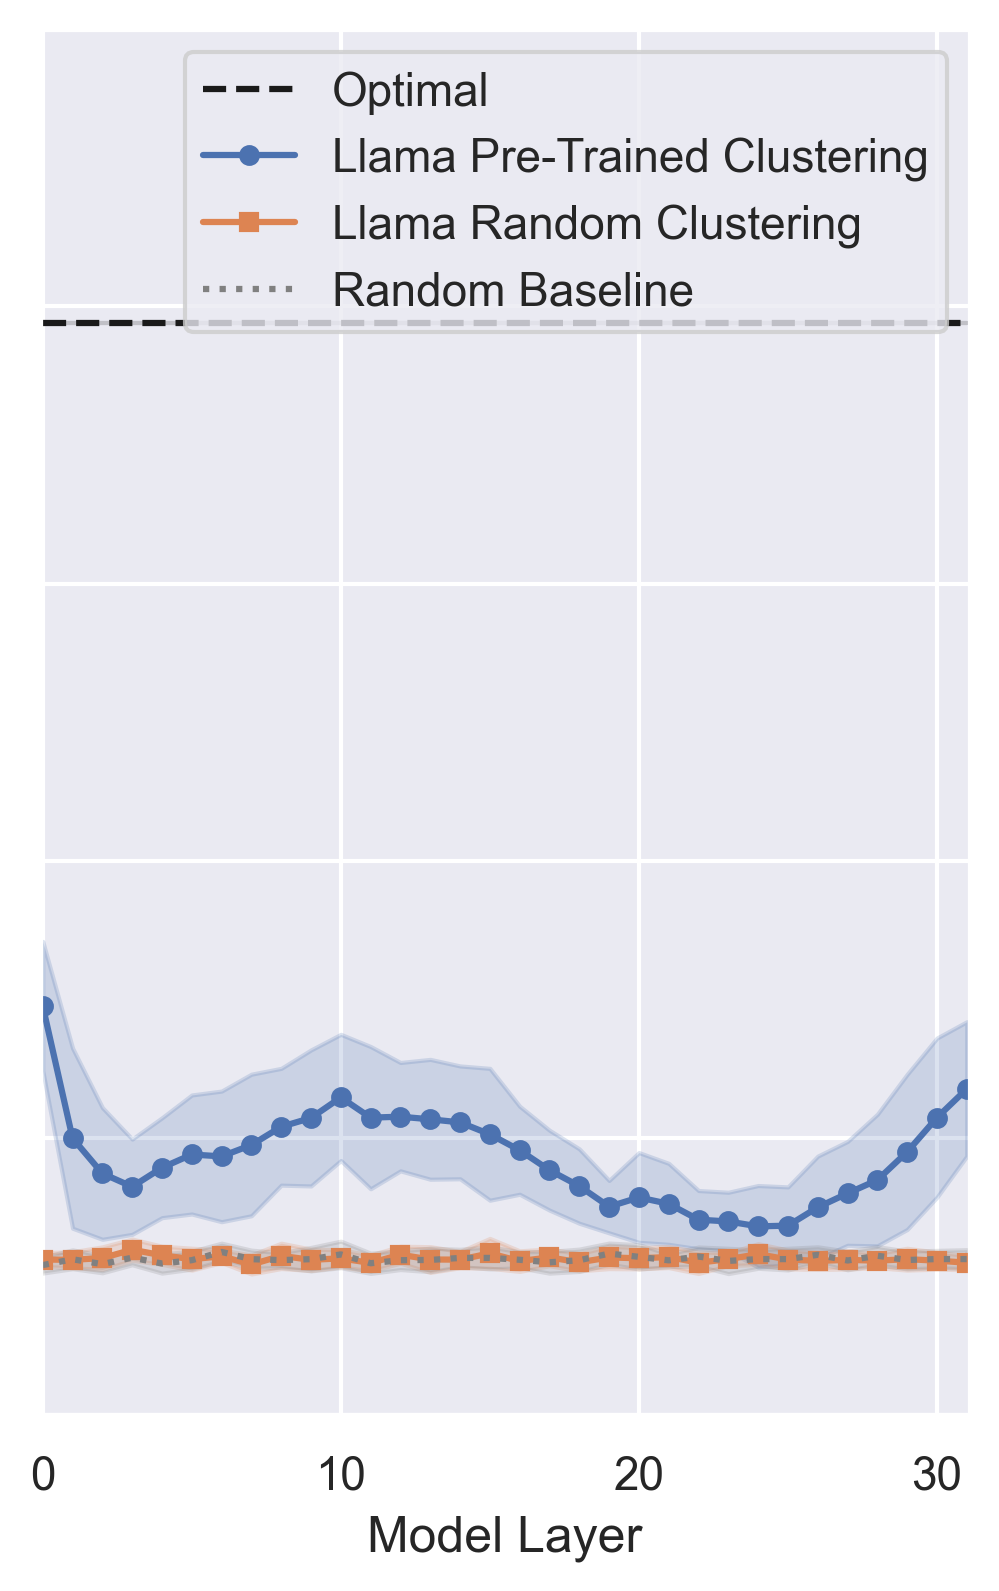

[0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062]
[[[0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.59245826709062, 0.5924

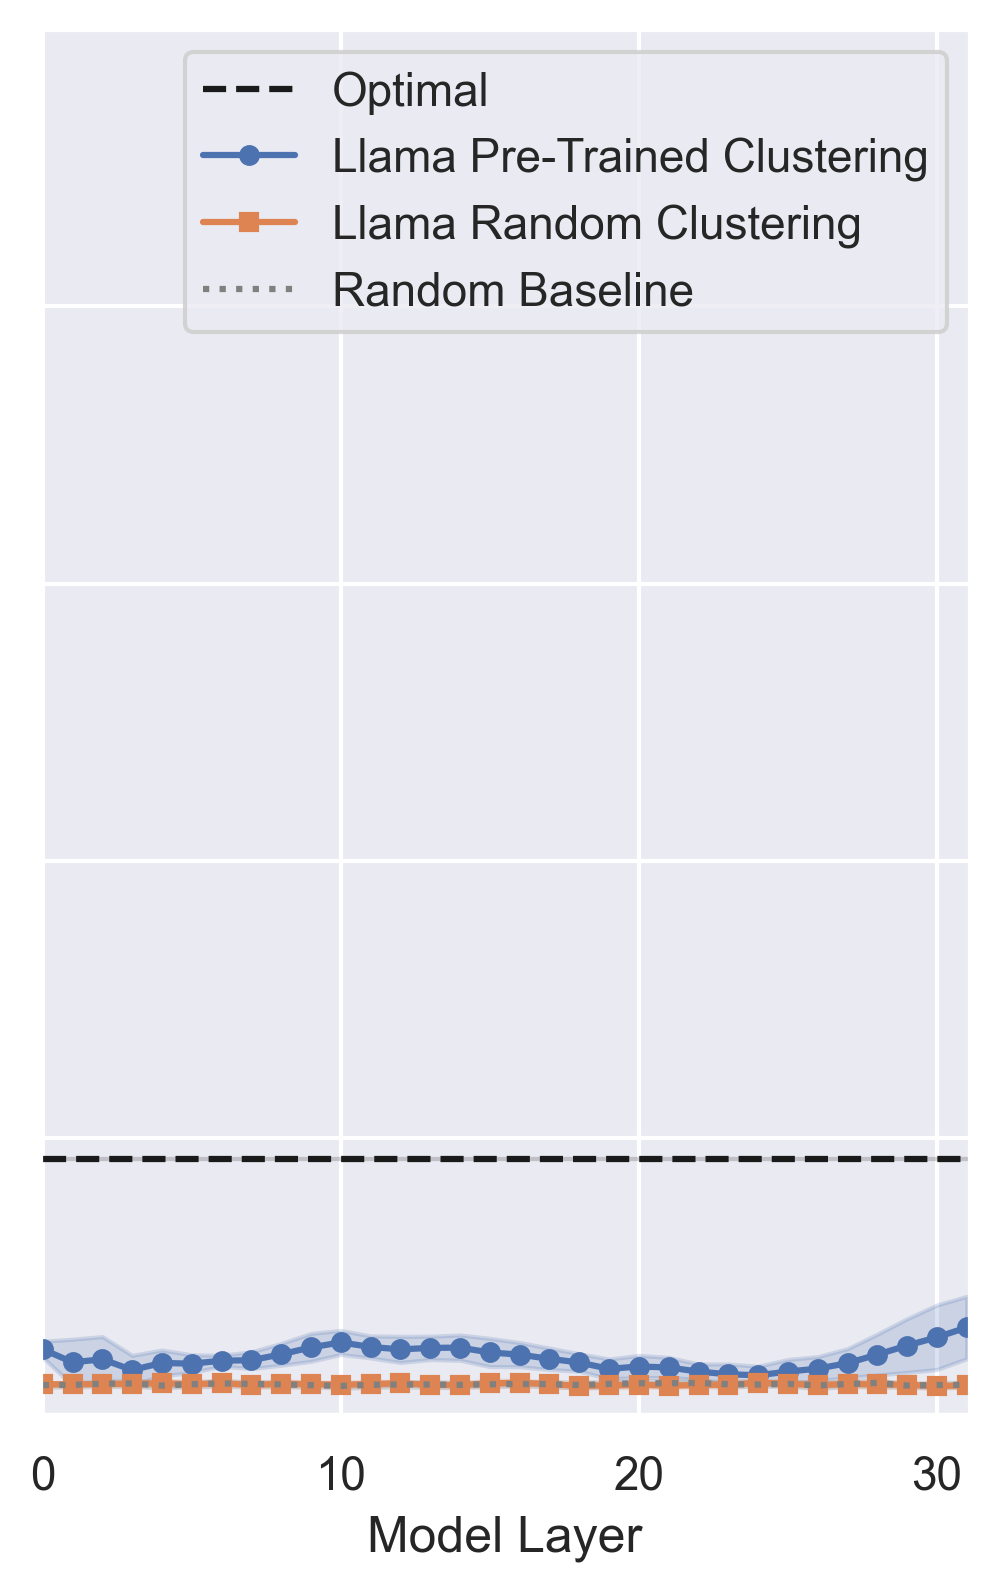

In [ ]:
all_layers = list(range(cfg.n_layers))
for pruning_ratio in [0.01, 0.02, 0.05, 0.1, 0.20, 0.8]:
    repo_aucs = []
    for repo in datasets:
        auc_tt, auc_rr, auc_rt, auc_tr, auc_ideal = [], [], [], [], []
        repo_aucs.append([auc_ideal, auc_tt, auc_rr, auc_rt, auc_tr])
        #repo_aucs.append([auc_ideal, auc_tt, auc_rt])
        for layer in all_layers:
            layers = [layer]
            good_ff_criteria = np.array( load_ff_criteria_auto("hf",   repo, pruning_ratio, layers=layers) )
            rand_ff_criteria = np.array( load_ff_criteria_auto("rand", repo, pruning_ratio, layers=layers) )

            auc_tt.append( area_under_curve(get_cumulative_counts(good_clusters_list[layers], good_ff_criteria)) )
            auc_rr.append( area_under_curve(get_cumulative_counts(rand_clusters_list[layers], rand_ff_criteria)) )
            auc_rt.append( area_under_curve(get_cumulative_counts(rand_clusters_list[layers], good_ff_criteria)) )
            auc_tr.append( area_under_curve(get_cumulative_counts(good_clusters_list[layers], rand_ff_criteria)) )
            auc_ideal.append( get_optimal_auc(pruning_ratio) )

        #plt.plot(all_layers, auc_tt, "-o", label="Trained Model, Trained Neurons")
        #plt.plot(all_layers, auc_rr, "-s", label="Random Model, Random Neurons")
        #plt.plot(all_layers, auc_rt, ":", label="Random Model, Trained Neurons")
        #plt.plot(all_layers, auc_tr, ":", label="Trained Model, Random Neurons")
        #plt.ylim(0.5, 1.0)
        #plt.legend()
        #plt.title(f"Pruning Ratio {pruning_ratio} in {repo}")
        #plt.show()

    print(auc_ideal)

    import seaborn as sns
    import einops
    sns.set_theme()

    print(repo_aucs)
    repo_aucs_arr = np.array(repo_aucs)

    repo_aucs_arr = einops.rearrange(repo_aucs_arr, "repo metric layer -> metric repo layer")
    print(repo_aucs_arr.shape)

    repo_x = np.arange(0, cfg.n_layers)
    repo_means = np.mean(repo_aucs_arr, axis=1)
    repo_stds = np.std(repo_aucs_arr, axis=1)

    datas = [
        {"fmt": "--", "color":"k", "label": "Optimal",},
        {"fmt": "-o", "color":"C0", "label": "Llama Pre-Trained Clustering"},
        {"fmt": "-s", "color":"C1", "label": "Llama Random Clustering"},
        {"fmt": ":",  "color":"grey", "label": "Random Baseline"},
        {"fmt": ":",  "color":"grey", "label": ""},
    ]

    plt.figure(figsize=(4,6))
    for i in [0,1,2,3]:
        fmt = datas[i]["fmt"]
        label = datas[i]["label"]
        color = datas[i]["color"]
        # Calculate the upper and lower bounds for the filled area
        lower_bound = repo_means[i] - repo_stds[i]
        upper_bound = repo_means[i] + repo_stds[i]
        # Plot the filled area
        plt.fill_between(repo_x, lower_bound, upper_bound, alpha=0.2, color=color)
        # Plot the mean line
        plt.plot(repo_x, repo_means[i], fmt, label=label, markersize=4, color=color)

    print(f"ROC Curves for Different Repos - Pruning Frac {pruning_ratio}")
    plt.ylim(0.5, 1.0)
    plt.xlim(-0.1, len(repo_x)-0.9)
    plt.legend(loc="upper right")
    plt.xlabel("Model Layer")
    plt.ylabel("Area Under Curve")
    if pruning_ratio > 0.01:
        plt.gca().set_yticklabels([])
        plt.ylabel("")
        #plt.gca().get_yaxis().set_visible(False)

    plt.show()